# Visualizations Join Fallecidos

## Content
- [Paths](#Paths)
- [Load data](#Load-data)
- [Life Expectancy oldest](#Life-Expectancy-oldest)
- [Life-expectancy-by-Estrato-main-20-cities](#Life-expectancy-by-Estrato-main-20-cities)
- [Life expectancy distribution by gender](#Life-expectancy-distribution-by-gender)

## Goal of visualization
- Show main visualitazions from aggregate data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import requests
import matplotlib
import re
from sodapy import Socrata
import configparser
import boto3
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
%load_ext autoreload
%autoreload 2

In [2]:
os.chdir(os.path.join(os.getcwd(), ".."))

In [3]:
from src.config import metadata
from src.utils.s3_utils import (get_censo_paths, download_files_from_s3, read_multiple_csv,
                                mk_partitioned_dir, identified_partitioned_dir)
from src.utils.general_utils import create_dir

## Paths

In [4]:
config = configparser.ConfigParser()
config.read('aws.cfg')
aws = config["AWS"]
bucket = "censo-covid"
s3 = boto3.resource('s3',
                    region_name="us-west-2",
                    aws_access_key_id=aws['AWS_ACCESS_KEY_ID'],
                    aws_secret_access_key=aws['AWS_SECRET_ACCESS_KEY'])
s3_client = boto3.client('s3',
                         aws_access_key_id=aws['AWS_ACCESS_KEY_ID'],
                         aws_secret_access_key=aws['AWS_SECRET_ACCESS_KEY']
                        )

# Local paths
data_path = os.path.join(os.getcwd(), "data")
censo_data_path = os.path.join(data_path, "censo")
covid_path = os.path.join(os.getcwd(), "data", "covid.csv")
divipola_path = os.path.join(os.getcwd(), "data", "divipola.csv")
#complete_fallecidos_path = os.path.join(data_path, "complete_fallecidos") # Heavy downloads
#complete_personas_path = os.path.join(data_path, "complete_fallecidos") # Really heavy download
aggregates_path = os.path.join(data_path,'aggregates')
aggregates_personas_path = os.path.join(aggregates_path, 'personas')
aggregates_fallecidos_path = os.path.join(aggregates_path, 'fallecidos')
aggregates_covid_path = os.path.join(aggregates_path, 'covid')
joins_path = os.path.join(data_path,'joins')
joins_personas_path = os.path.join(joins_path, 'personas')
joins_fallecidos_path = os.path.join(joins_path,'fallecidos')

# S3 paths
censo_covid_bucket_s3 = f"s3a://{bucket}"

raw_data_path_s3 = os.path.join(censo_covid_bucket_s3, "raw-data")
censo_data_path_s3 = os.path.join(raw_data_path_s3, "censo")
covid_tests_path_s3 = os.path.join(raw_data_path_s3, "covid-tests.csv")
covid_path_s3 = os.path.join(raw_data_path_s3, "covid.csv")
divipola_path_s3 = os.path.join(raw_data_path_s3, "divipola.csv")

final_data_path_s3 = os.path.join(censo_covid_bucket_s3, "final-data")
#complete_personas_path = os.path.join(final_data_path, "complete_personas")# Heavy downloads
#complete_fallecidos_path = os.path.join(final_data_path, "complete_fallecidos")# Really heavy download

aggregates_personas_path_s3 = os.path.join(final_data_path_s3, "aggregates_personas")
aggregates_fallecidos_path_s3 = os.path.join(final_data_path_s3, "aggregates_fallecidos")
aggregates_covid_path_s3 = os.path.join(final_data_path_s3, "aggregates_covid")

join_personas_covid_path_s3 = os.path.join(final_data_path_s3, "join_personas_covid")
join_fallecidos_covid_path_s3 = os.path.join(final_data_path_s3, "join_fallecidos_covid")

s3Bucket = s3.Bucket(bucket)

# Load data

In [5]:
create_dir(joins_fallecidos_path)

/Users/camilovelasquez/Desktop/Documents/Camilo/Udacity/censo_covid_colombia/data/joins/fallecidos dir exists


In [6]:
download_files_from_s3(joins_fallecidos_path, s3Bucket,
                       prefix=join_fallecidos_covid_path_s3.replace(censo_covid_bucket_s3 + "/", ""))

Already downloaded final-data/join_fallecidos_covid


In [7]:
to_concat, list_files = read_multiple_csv(joins_fallecidos_path, to_concat=[],
                                          list_of_files=[], header=0, n_files=10)

In [8]:
df = pd.concat(to_concat)
df.head()

,dpto,nom_mpio,Number_of_people_fallecidos,Number_of_dead_males,Number_of_dead_females,Avg_Age_w_0s,Avg_Death_Age,Avg_Death_Age_Male,Avg_Death_Age_Female,Avg_Death_Age_Estrato1,Avg_Death_Age_Estrato2,Avg_Death_Age_Estrato3,Avg_Death_Age_Estrato4,Avg_Death_Age_Estrato5,Avg_Death_Age_Estrato6,Number_of_dead_Estrato1,Number_of_dead_Estrato2,Number_of_dead_Estrato3,Number_of_dead_Estrato4,Number_of_dead_Estrato5,Number_of_dead_Estrato6,Avg_Death_Age_Cabecera,Avg_Death_Age_Centro_Poblado,Avg_Death_Age_Rural_Disperso,Avg_Death_Age_Resto_Rural,Number_of_dead_Cabecera,Number_of_dead_Centro_Poblado,Number_of_dead_Rural_Disperso,Number_of_dead_Resto_Rural,Number_of_people_covid,Number_of_males_covid,Number_of_females_covid,Number_of_deaths,Number_of_non_deaths,Sum_of_dead_ages,edad_q_1,edad_q_2,edad_q_3,edad_q_4,edad_q_5,edad_q_6,edad_q_7,edad_q_8,edad_q_9,edad_q_10,edad_q_11,edad_q_12,edad_q_13,edad_q_14,edad_q_15,edad_q_16,edad_q_17,edad_q_18,edad_q_19,edad_q_20,edad_q_21,estado_Asintomático,estado_Fallecido,estado_Grave,estado_Leve,estado_Moderado,estado_N/A,atenci_n_Casa,atenci_n_Fallecido,atenci_n_Hospital,atenci_n_Hospital UCI,atenci_n_N/A,atenci_n_Recuperado
0,ANTIOQUIA,TURBO,607,370,237.0,46.602965,65.410390,63.559633,67.826347,65.736156,62.283019,69.588235,NaN,NaN,NaN,493,71.0,20.0,NaN,NaN,NaN,63.333333,NaN,NaN,66.651452,242.0,NaN,NaN,365.0,291,229.0,62.0,8.0,283.0,626,29,58,15,11,49,1,34,35,27,5,4,11,2,4,0,4,0,1,1,0,0,6,8,2,261,14,0,125,8,13,2,0,143
1,ATLÁNTICO,SANTO TOMÁS,126,80,46.0,68.595238,72.720339,69.800000,77.813953,67.439024,73.462963,81.666667,NaN,NaN,NaN,46,56.0,21.0,NaN,NaN,NaN,72.256637,NaN,NaN,83.200000,120.0,NaN,NaN,6.0,287,159.0,128.0,11.0,276.0,761,8,37,16,26,37,2,21,30,24,5,11,23,20,3,7,2,6,8,1,0,0,18,10,3,242,13,1,119,10,12,3,1,142
2,ANTIOQUIA,ENVIGADO,863,448,414.0,67.424102,76.959947,74.194301,77.361878,65.500000,72.581921,78.740181,74.27957,80.6,75.2,6,252.0,354.0,98.0,144.0,7.0,77.166432,NaN,NaN,73.300000,819.0,NaN,NaN,44.0,281,136.0,145.0,1.0,280.0,51,4,34,22,27,49,0,24,31,28,3,7,23,13,4,1,5,4,1,1,0,0,4,1,3,261,12,0,193,1,11,3,0,73
3,BOLÍVAR,MAGANGUÉ,793,461,331.0,65.016393,73.664212,70.924084,74.074324,73.813830,70.927083,77.500000,82.00000,NaN,NaN,662,106.0,6.0,2.0,NaN,NaN,72.876777,NaN,NaN,74.957198,508.0,NaN,NaN,285.0,243,105.0,138.0,18.0,225.0,1293,12,29,10,12,33,3,30,24,17,12,8,10,6,6,4,8,7,7,3,0,2,1,18,1,178,42,3,131,18,42,1,2,49
4,ATLÁNTICO,POLONUEVO,75,39,36.0,70.546667,74.085714,73.000000,75.171429,72.891892,75.592593,74.666667,NaN,NaN,NaN,41,28.0,6.0,NaN,NaN,NaN,74.967213,NaN,NaN,68.111111,65.0,NaN,NaN,10.0,216,110.0,106.0,7.0,209.0,499,11,18,17,13,28,1,23,27,16,2,6,15,11,6,6,4,4,6,1,1,0,14,7,2,189,4,0,124,7,4,2,0,79


In [9]:
df["covid_avg_death_age"] = df["Sum_of_dead_ages"]/df["Number_of_deaths"]

### Covid Avg death age vs Expected death age by city

In [10]:
look_up_columns = ["dpto", "nom_mpio", "Number_of_people_fallecidos", 
                   "Avg_Death_Age", "covid_avg_death_age", "Number_of_deaths"]
aux = df[look_up_columns].sort_values("Number_of_people_fallecidos", ascending=False)[:100]
aux = aux.drop(columns=["Number_of_people_fallecidos", "Number_of_deaths"]).set_index(["dpto", 
                                                                   "nom_mpio"]).stack().to_frame().reset_index()
aux.columns = ["dpto", "nom_mpio", "Source", "Life Expectancy"]
aux["Source"] = aux["Source"].map({"Avg_Death_Age": "Censo", "covid_avg_death_age": "Covid"})

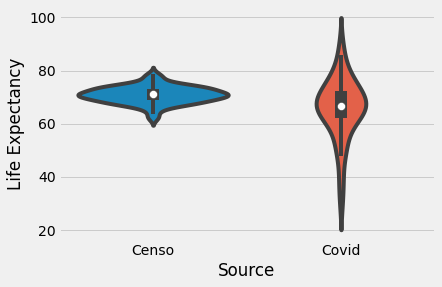

In [11]:
sns.violinplot(data=aux, x="Source", y="Life Expectancy")
plt.show()

## Calculating avg years lost by covid

**COVID has reduced the expected life in around 5 years, mean and median are close, and is geting the top 100 cities with deaths**

In [12]:
look_up_columns = ["dpto", "nom_mpio", "Number_of_people_fallecidos", 
                   "Avg_Death_Age", "covid_avg_death_age", "Number_of_deaths"]
aux = df[look_up_columns].sort_values("Number_of_people_fallecidos", ascending=False)[:100]

In [13]:
aux["Diff_covid_censo"] = aux["covid_avg_death_age"] - aux["Avg_Death_Age"]

In [14]:
aux["Diff_covid_censo"].describe()

count    50.000000
mean     -5.501432
std      11.848283
min     -37.710280
25%      -8.948761
50%      -4.459496
75%       1.149767
max      18.760274
Name: Diff_covid_censo, dtype: float64

### Look at cities life expectancies

In [15]:
import plotly.express as px

In [25]:
df_plot = aux
df_plot["name"] = df_plot["dpto"] + "-" + df_plot["nom_mpio"]
df_plot = df_plot.drop(columns=["dpto", "nom_mpio"])
df_plot.columns = ['Number_of_deaths_CENSO', 'Life_Expectancy_Censo',
                   'Avg_Death_Age_Covid', 'Number_of_deaths_COVID', 
                   'Expectancy_difference', 'Dpto-Mpio']

In [36]:
fig = px.scatter(df_plot[:40], x="Life_Expectancy_Censo", y="Avg_Death_Age_Covid", text="Dpto-Mpio", 
                 size_max=100, color="Expectancy_difference")
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Life Expectency vs Avg age COVID death by City', title_x=0.5)
fig.show()